<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/P1_EULER_IMPLICIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Volem trobar els valors de les temperatures de la següent forma:

$\vec{T_i}=M^{-1}(\vec{T_{i-1}}+\vec{\Delta t})$


T_0= 674.2857142857143
amb un dt= 0.0001 , calen 252 iteracions per arribar al temps normalitzat 0.025099999999999904
amb un dt= 5e-05 , calen 501 iteracions per arribar al temps normalitzat 0.025000000000000203


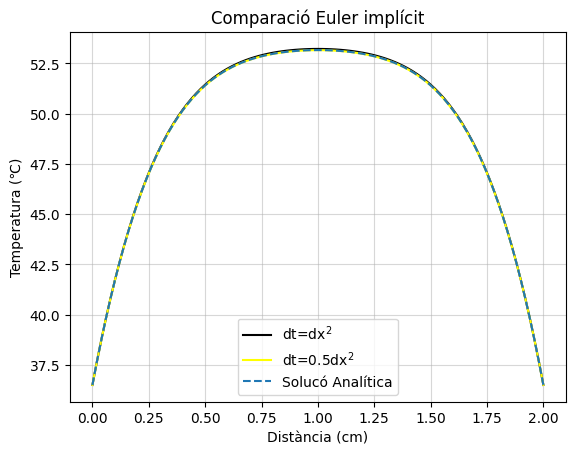

In [28]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import matplotlib.patches as pt

# CÀLCULS PREVIS
# Recordem que les nostres dades són
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40
# Amb aquests, calculem la difusivitat, que farem servir per a la normalització
alpha= kappa/(C_v*rho)
# Imposem la nostra normalització
N= 101
x_0= 0.02 # Triat per tal de normalitzar x_f, que ha de ser 0.02 m (2 cm)
x_f= 0.02/x_0
t_0= x_0**2/alpha # \tilde{t}=t/t_0
t_f= 0.025 # Ja està normalitzat, ho diu l'enunciat
P_ext= volts**2*sigma/(2*(x_0)**2) # Calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 # Unitats=Kelvin
print("T_0=", T_0)
T_init= 309.65/T_0 # Hem passat la temperatura inicial 36.5℃ a kelvin i després l'hem normalitzat

# Definim els dos casos de variacions de les variables
dx= x_f/(N-1) # Com tenim N punts, tenim N-1 intervals
dt_1= dx**2
dt_2= 0.5*dx**2

# Creem una funció aplicable a qualsevol temperatura inicial (sempre que sigui la mateixa temperatura que als contorns),
def Euler_implicit (T_i, t_f, dx, dt): # Li has de passar les variables (escalars) normalizades
    T_i_vec=np.ones((N,1))*T_i
    i= 1
    t_i= 0
    # Creem la matriu M
    gamma= dt/(dx**2)
    col1= [0]*(N)
    fila1= [0]*(N)
    col1[0] = fila1[0] = 1 + 2*gamma
    col1[1] = fila1[1] = -gamma
    matriu = toeplitz(col1, fila1) # Crea una matriu tridiagonal amb 1-2gamma a la diagonal princial i -gamma a les diagonals de sobre i de sota
    #IMPOSEM LES CONDICIONS DE CONTORN
    matriu[0,:]  = 0 #això vol dir que tots els elements (:) de la primera fila (la fila 0, corresponent al temps inicial t=0) valen 0
    matriu[0,0]  = 1 #i després de fer que tots els elements valguin 0 fas que el primer (el de la primera fila i la primera columna
                          #és a dir, el primer de la diagonal) valgui 1, de forma que quan multipliques la matriu per T_inic et continua
                          #quedant T_inic
    matriu[-1,:] = 0 #el mateix que abans, fas que tots els elements de la última fila siguin 0 excepte el de l'última columna, és a dir,
                          #l'últim de la diagonal, el qual val 1
    matriu[-1,-1]= 1

    while t_i<t_f: #com la nostra equació és de la forma Ax=b, on A=inv(M) i x=\vec{T_i}, anem a trobar b=\vec{T_{i-1}+∆t}
      # I apliquem això per trobar T_i_vec
      b = T_i_vec + np.ones((N,1))*dt
      b[0]  = T_i
      b[-1] = T_i
      T_i_vec = np.matmul(inv(matriu), b)
      T_i_vec[0]  = T_i
      T_i_vec[-1] = T_i
      t_i = t_i + dt
      i = i + 1
    print("amb un dt=",dt,", calen",i,"iteracions per arribar al temps normalitzat", t_i)
    return T_i_vec

# Apliquem la funció que hem creat als nostres dos casos de discretitzacions
T_i_1 = Euler_implicit(T_init, t_f, dx, dt_1)
T_i_2 = Euler_implicit(T_init, t_f, dx, dt_2)

# Temperatures reals, desfem la normalització i passem a ℃
T_real_1 = T_i_1 * T_0 - 273.15
T_real_2 = T_i_2 * T_0 - 273.15

# print(T_real_1)
# # print(T_real_2)
# ... tot el teu codi d'Euler implícit igual ...

dx_llista = np.linspace(0, 2, 101) # Eix x en cm
plt.plot(dx_llista, T_real_1, color="k", label="dt=dx$^2$")
plt.plot(dx_llista, T_real_2, color="yellow", label="dt=0.5dx$^2$")
plt.xlabel("Distància (cm)")
plt.ylabel("Temperatura (℃)")
plt.legend()
plt.title("Comparació Euler implícit")


N_terms = 1000   # Termes sèrie de Fourier

def T_analytic_hat(x_hat, t_f, T_init, N):
    x_arr = np.asarray(x_hat, dtype=float)
    n = np.arange(1, N + 1)        # n = 1,2,...,N  → k = 1,3,5,...,2N-1
    k = 2*n - 1
    coeff = 4.0 / (k**3 * np.pi**3) * (1.0 - np.exp(-k**2 * np.pi**2 * t_f))
    sin_term = np.sin(np.outer(k, np.pi * x_arr))
    T_hat = T_init + np.sum(coeff[:, None] * sin_term, axis=0)
    if np.isscalar(x_hat):
        return float(T_hat[0])
    return T_hat
x_hat = dx_llista / 2.0                 # passem de cm → x̂ ∈ [0,1]
T_hat_analytic = T_analytic_hat(x_hat, t_f, T_init, N_terms)
T_real_analitica = (T_hat_analytic * T_0)- 273.15  # °C

plt.plot(dx_llista, T_real_analitica, "--", label="Solucó Analítica")
plt.grid(True, alpha=0.5)
# plt.xlim(0.99,1.01)
# plt.ylim(53.15,53.25) # Per veure la diferència
plt.legend()
plt.show()